<a href="https://colab.research.google.com/github/StefanGarcziu/DeepLearning_5semester/blob/main/DL_Zad4_StepanGarciu_135843.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A regression example**

Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.

In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# install optuna
! pip install optuna

In [3]:
import optuna

**1-dimensional data**

In [4]:
def funct(x):
  return x*x*np.sin(x)+np.log(2*x)

size = 200
low=0
high=12
error=20

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(200,) (200,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

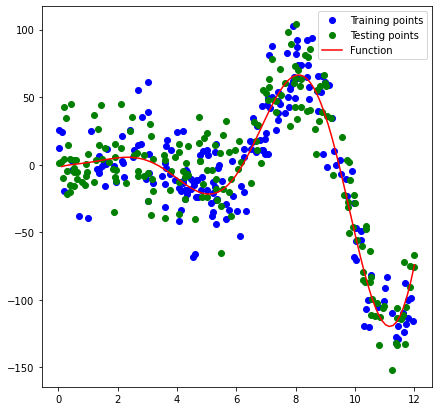

In [5]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show

**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:

In [6]:
# Tutaj należy znormalizować dane, i.e. 
# - odjąć średnią
# - podzielić przez odchylenie standardowe

# 
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

# to samo dla x_test
XX_test_n = XX_test - mean
XX_test_n /= std

mean1 = yy_train.mean(axis=0)
yy_train_n = yy_train-mean1
std1 = yy_train_n.std(axis=0)
yy_train_n /= std1

# to samo dla y_test
yy_test_n = yy_test - mean1
yy_test_n /= std1

# A teraz to samo dla yy_train i yy_test
# dopisać to samo dla y

Define neural network

In [7]:
# Zbudować sieć neuronową, działa: dwie warstwy ukryte, aktywacja relu
from keras import models
from keras import layers

In [8]:
def objective(trial):
    units = trial.suggest_discrete_uniform('units', 8, 2048, 1)
    dropout = trial.suggest_uniform('dropout', 0, 0.5)
    lr = trial.suggest_float('lr',0.0005, 0.002, log=True)
    act= trial.suggest_categorical('activation',['relu','sigmoid','linear'])

    model0 = Sequential(name='network')
    #.....
    model0.add(layers.Dense(units, activation=act, input_shape=(1,)))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(units, activation=act))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(1, activation='linear'))
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
    #model0.summary()
    opt=optimizers.RMSprop(lr=lr)
    model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
    history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
    results = model0.evaluate(XX_test_n, yy_test_n)
    return results[0]

In [9]:
study = optuna.create_study()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=20)

study.best_params 

[I 2020-12-09 18:00:24,323] A new study created in memory with name: no-name-2079e792-0832-4ebe-8e1a-c379627c4a9f
[I 2020-12-09 18:00:24,326] A new study created in memory with name: no-name-01d996af-dfb5-4cb4-a278-eb033a43a078


Epoch 00095: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.8756 - mse: 0.8756


[I 2020-12-09 18:00:28,067] Trial 0 finished with value: 0.8755643367767334 and parameters: {'units': 224.0, 'dropout': 0.4954256788964758, 'lr': 0.0010101903037339182, 'activation': 'linear'}. Best is trial 0 with value: 0.8755643367767334.


Epoch 00084: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.9891 - mse: 0.9891


[I 2020-12-09 18:00:30,405] Trial 1 finished with value: 0.9891334772109985 and parameters: {'units': 1526.0, 'dropout': 0.14332682435853805, 'lr': 0.0013370226395689074, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.8755643367767334.


Epoch 00095: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1987 - mse: 0.1987


[I 2020-12-09 18:00:32,812] Trial 2 finished with value: 0.19873863458633423 and parameters: {'units': 376.0, 'dropout': 0.27915582038102393, 'lr': 0.0013706061404429402, 'activation': 'relu'}. Best is trial 2 with value: 0.19873863458633423.


Epoch 00099: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.8780 - mse: 0.8780


[I 2020-12-09 18:00:35,275] Trial 3 finished with value: 0.8779668211936951 and parameters: {'units': 768.0, 'dropout': 0.4153696713682228, 'lr': 0.0013710371730390838, 'activation': 'linear'}. Best is trial 2 with value: 0.19873863458633423.


Epoch 00262: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2331 - mse: 0.2331


[I 2020-12-09 18:00:41,557] Trial 4 finished with value: 0.2330784797668457 and parameters: {'units': 1878.0, 'dropout': 0.3667001383571827, 'lr': 0.0005915701823074618, 'activation': 'relu'}. Best is trial 2 with value: 0.19873863458633423.


Epoch 00076: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.8958 - mse: 0.8958


[I 2020-12-09 18:00:43,794] Trial 5 finished with value: 0.8957996368408203 and parameters: {'units': 215.0, 'dropout': 0.07650398263154923, 'lr': 0.0005676994616347687, 'activation': 'linear'}. Best is trial 2 with value: 0.19873863458633423.


Epoch 00133: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1994 - mse: 0.1994


[I 2020-12-09 18:00:46,961] Trial 6 finished with value: 0.19940848648548126 and parameters: {'units': 974.0, 'dropout': 0.2655304622377676, 'lr': 0.0015492680452204777, 'activation': 'relu'}. Best is trial 2 with value: 0.19873863458633423.


Epoch 00069: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.0504 - mse: 1.0504


[I 2020-12-09 18:00:48,925] Trial 7 finished with value: 1.0503551959991455 and parameters: {'units': 657.0, 'dropout': 0.23479757087807734, 'lr': 0.000809904111691024, 'activation': 'sigmoid'}. Best is trial 2 with value: 0.19873863458633423.


Epoch 00185: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2015 - mse: 0.2015


[I 2020-12-09 18:00:52,990] Trial 8 finished with value: 0.20152287185192108 and parameters: {'units': 349.0, 'dropout': 0.3058569889361619, 'lr': 0.0008396285764200849, 'activation': 'relu'}. Best is trial 2 with value: 0.19873863458633423.


7/7 [==============================] - 0s 2ms/step - loss: 0.2077 - mse: 0.2077


[I 2020-12-09 18:01:03,374] Trial 9 finished with value: 0.20771226286888123 and parameters: {'units': 1233.0, 'dropout': 0.43081838263085065, 'lr': 0.0009401582655666743, 'activation': 'sigmoid'}. Best is trial 2 with value: 0.19873863458633423.


Epoch 00221: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1918 - mse: 0.1918


[I 2020-12-09 18:01:08,159] Trial 10 finished with value: 0.19179609417915344 and parameters: {'units': 58.0, 'dropout': 0.17656531403008602, 'lr': 0.001900080146390628, 'activation': 'relu'}. Best is trial 10 with value: 0.19179609417915344.


Epoch 00178: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1974 - mse: 0.1974


[I 2020-12-09 18:01:12,095] Trial 11 finished with value: 0.19737756252288818 and parameters: {'units': 487.0, 'dropout': 0.17471784260023945, 'lr': 0.001923732275060687, 'activation': 'relu'}. Best is trial 10 with value: 0.19179609417915344.


Epoch 00320: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1992 - mse: 0.1992


[I 2020-12-09 18:01:18,934] Trial 12 finished with value: 0.19921354949474335 and parameters: {'units': 48.0, 'dropout': 0.15929115427501545, 'lr': 0.0019033259238143202, 'activation': 'relu'}. Best is trial 10 with value: 0.19179609417915344.


Epoch 00155: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2024 - mse: 0.2024


[I 2020-12-09 18:01:22,458] Trial 13 finished with value: 0.2024354785680771 and parameters: {'units': 18.0, 'dropout': 0.019677676818332296, 'lr': 0.0019450954497719883, 'activation': 'relu'}. Best is trial 10 with value: 0.19179609417915344.


Epoch 00210: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1931 - mse: 0.1931


[I 2020-12-09 18:01:27,001] Trial 14 finished with value: 0.19310417771339417 and parameters: {'units': 599.0, 'dropout': 0.1709262457889005, 'lr': 0.001972259509366055, 'activation': 'relu'}. Best is trial 10 with value: 0.19179609417915344.


Epoch 00250: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1988 - mse: 0.1988


[I 2020-12-09 18:01:32,703] Trial 15 finished with value: 0.19879421591758728 and parameters: {'units': 885.0, 'dropout': 0.08589252351694829, 'lr': 0.0016507953433347712, 'activation': 'relu'}. Best is trial 10 with value: 0.19179609417915344.


Epoch 00362: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1855 - mse: 0.1855


[I 2020-12-09 18:01:40,434] Trial 16 finished with value: 0.18547703325748444 and parameters: {'units': 1267.0, 'dropout': 0.21265666278230785, 'lr': 0.0011274696906762919, 'activation': 'relu'}. Best is trial 16 with value: 0.18547703325748444.


Epoch 00161: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2296 - mse: 0.2296


[I 2020-12-09 18:01:44,272] Trial 17 finished with value: 0.22958849370479584 and parameters: {'units': 1348.0, 'dropout': 0.2317438547299526, 'lr': 0.0011583866291521568, 'activation': 'relu'}. Best is trial 16 with value: 0.18547703325748444.


Epoch 00089: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2043 - mse: 0.2043


[I 2020-12-09 18:01:46,813] Trial 18 finished with value: 0.20434384047985077 and parameters: {'units': 1815.0, 'dropout': 0.3280433070217674, 'lr': 0.0006541711687500174, 'activation': 'relu'}. Best is trial 16 with value: 0.18547703325748444.


Epoch 00300: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1920 - mse: 0.1920


[I 2020-12-09 18:01:53,576] Trial 19 finished with value: 0.19204182922840118 and parameters: {'units': 1613.0, 'dropout': 0.09960797077195843, 'lr': 0.0011328879826936625, 'activation': 'relu'}. Best is trial 16 with value: 0.18547703325748444.


{'activation': 'relu',
 'dropout': 0.21265666278230785,
 'lr': 0.0011274696906762919,
 'units': 1267.0}

## Visualizing the Optimization History

In [10]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [11]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study, params=['units', 'dropout'])

## Visualizing Parameter Relationships

In [12]:
from optuna.visualization import plot_contour

plot_contour(study)

## Selecting Parameters to Visualize

In [13]:
plot_contour(study, params=['units', 'dropout'])

## Visualizing Individual Parameters

In [14]:
from optuna.visualization import plot_slice

plot_slice(study)

## Selecting Parameters to Visualize

In [15]:
plot_slice(study, params=['units', 'dropout'])

## Visualizing Parameter Importances

In [16]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [17]:
trial = study.best_trial
units = int(trial.params.get('units'))
dropout = (trial.params.get('dropout'))
print(units)
print(dropout)

1267
0.21265666278230785


In [18]:
model0 = Sequential(name='network')
    #.....
model0.add(layers.Dense(units, activation='relu', input_shape=(1,)))
model0.add(Dropout(dropout))
model0.add(layers.Dense(units, activation='relu'))
model0.add(Dropout(dropout))
model0.add(layers.Dense(1, activation='linear'))
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
#model0.summary()
opt=optimizers.RMSprop(lr=0.001)
model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
results = model0.evaluate(XX_test_n, yy_test_n)

Epoch 00275: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2060 - mse: 0.2060


Plot loss

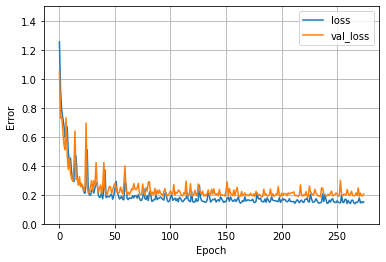

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

plot_loss(history)

Evaluate neural network

In [20]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.2060 - mse: 0.2060
loss test data:  0.20595870912075043
mse test data:  0.20595870912075043
7/7 [==============================] - 0s 2ms/step - loss: 0.1543 - mse: 0.1543
loss train data:  0.1543184220790863
mse train data:  0.1543184220790863


Plot results

<function matplotlib.pyplot.show>

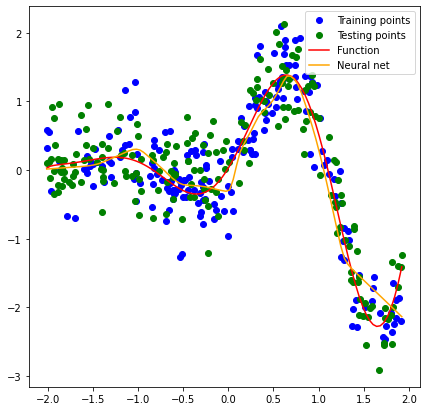

In [21]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-mean1)/std1,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')


plt.legend()


plt.show